In [ ]:
import numpy as np
from deephive.environment.optimization_functions.benchmark_functions import *

In [ ]:
function_selector = FunctionSelector()

In [201]:
class PSOBSA:
    def __init__(self, fitness_function, dimension, swarm_size, inertia_weight, 
                 acc_coefficients, mix_rate, mutation_probability, neighborhood_size,
                 lower_bound=-100, upper_bound=100, scale = False):
        self.scale_option = scale
        self.num_evaluations = 0
        self.lower_bound = lower_bound  
        self.upper_bound = upper_bound
        self.obj_function = fitness_function
        self.dimension = dimension
        self.swarm_size = swarm_size
        self.inertia_weight = inertia_weight
        self.acc_coefficients = acc_coefficients  # This is a tuple (c1, c2)
        self.mix_rate = mix_rate
        self.mutation_probability = mutation_probability
        self.neighborhood_size = neighborhood_size
        self.positions = np.random.uniform(low=lower_bound, high=upper_bound, size=(swarm_size, dimension))
        if self.scale_option:
            self.positions = self.scale(self.positions)
        self.velocities = np.zeros((swarm_size, dimension))
        self.pbest_positions = np.copy(self.positions)
        self.gbest_position = self.positions[np.argmin(self.fitness_function(self.positions))]
        self.fitness_values = self.fitness_function(self.positions)
        
    def fitness_function(self, positions):
        self.num_evaluations += len(positions)
        if self.scale_option:
            return self.obj_function(self.unscale(positions))
        return self.obj_function(positions)
        
    def scale(self, observation: np.ndarray) -> np.ndarray:
        low = self.lower_bound
        high = self.upper_bound
        # Scale the observation to the range [0, 1]
        scaled_obs = (observation - low) / (high - low)
        # Stretch and shift the [0, 1] interval to [-1, 1]
        return scaled_obs 
    
    def unscale(self, observation: np.ndarray) -> np.ndarray:
        low = self.lower_bound
        high = self.upper_bound
        # Shift and compress the [-1, 1] interval back to [0, 1]
        unscaled_obs = observation 
        # Unscale the observation back to the original range
        return unscaled_obs * (high - low) + low
    
    def initialize_neighborhoods(self):
        self.neighborhoods = []
        for i in range(self.swarm_size):
            neighborhood_indices = list(range(i - self.neighborhood_size, i)) + list(range(i + 1, i + 1 + self.neighborhood_size))
            neighborhood_indices = [index % self.swarm_size for index in neighborhood_indices]  # Ensure indices are within bounds
            self.neighborhoods.append(neighborhood_indices)
    
    def compute_lbest(self):
        self.lbest_positions = np.zeros((self.swarm_size, self.dimension))
        for i in range(self.swarm_size):
            neighborhood_fitnesses = self.fitness_values[self.neighborhoods[i]]
            best_neighbor_idx = self.neighborhoods[i][np.argmin(neighborhood_fitnesses)]
            self.lbest_positions[i] = self.positions[best_neighbor_idx]
    
    def update_velocity(self):
        r1, r2 = np.random.rand(self.swarm_size, self.dimension), np.random.rand(self.swarm_size, self.dimension)
        cognitive_component = self.acc_coefficients[0] * r1 * (self.pbest_positions - self.positions)
        social_component = self.acc_coefficients[1] * r2 * (self.gbest_position - self.positions)
        self.velocities = self.inertia_weight * self.velocities + cognitive_component + social_component
    
    def update_positions(self):
        self.positions += self.velocities
        # confirm the position is within the search space
        if self.scale_option:
            self.positions = np.clip(self.positions, 0, 1)
        else:
            self.positions = np.clip(self.positions, self.lower_bound, self.upper_bound)
        if self.scale_option:
            #print(self.positions)
            assert np.all((self.positions >= 0) & (self.positions <= 1))
        else:
           # print(self.positions)
            assert np.all((self.positions >= self.lower_bound) & (self.positions <= self.upper_bound))
        #Boundary conditions and velocity limits would be handled here

    def calculate_fitness(self):
        self.fitness_values = self.fitness_function(self.positions)
        # Update pbest and gbest here

    def mutate(self, positions, lbest_positions):
        # Eq. (12) from the description:
        # Tij = Xij + A(φ × Lbest - Xij)
        A = 2 * np.random.rand(self.swarm_size, self.dimension)
        phi = np.random.rand(self.swarm_size, self.dimension)
        return positions + A * (phi * lbest_positions - positions)
    
    def crossover(self, positions, trial_positions):
        # For each dimension, we have a mix rate chance of taking the value from the trial position
        crossover_mask = np.random.rand(self.swarm_size, self.dimension) < self.mix_rate
        new_positions = np.where(crossover_mask, trial_positions, positions)
        return new_positions

    # Placeholder for the main optimization loop
    def optimize(self, iterations):
        self.initialize_neighborhoods()
        for _ in range(iterations):
            self.compute_lbest()  # Compute Lbest positions
            self.update_velocity()
            self.update_positions()
            self.calculate_fitness()
            # Mutation and Crossover
            self.positions = self.mutate_and_crossover(self.positions, self.lbest_positions)
        return self.gbest_position
    
    def mutate_and_crossover(self, positions, lbest_positions):
        # Mutation and Crossover
        for i in range(self.swarm_size):
            if np.random.rand() < self.mutation_probability:
                trial_positions = self.mutate(positions, lbest_positions)
            else:
                self.permute_lbest(i)
                trial_positions = self.mutate(positions, lbest_positions[i])

            new_positions = self.crossover(positions, trial_positions)
            new_fitness = self.fitness_function(new_positions)

            # Selection-II: Update the personal and global bests
            better_mask = new_fitness < self.fitness_values
            positions[better_mask] = new_positions[better_mask]
            self.pbest_positions[better_mask] = new_positions[better_mask]
            self.fitness_values[better_mask] = new_fitness[better_mask]

            if np.min(new_fitness) < self.fitness_function(self.gbest_position.reshape(1, -1)):
                self.gbest_position = new_positions[np.argmin(new_fitness)]
        return positions
    
    def permute_lbest(self, particle_index):
        # Apply a permutation to the lbest of the selected particle
        # This is a simplification; in reality, you might want to shuffle the entire neighborhood
        neighbor_indices = self.neighborhoods[particle_index]
        np.random.shuffle(neighbor_indices)
        self.lbest_positions[particle_index] = self.positions[neighbor_indices[0]]


function = function_selector.get_function('f01')
fitness_function = function['func']
dimension = function['dimension']
lower_bound = function['domain'][0]
upper_bound = function['domain'][1]
global_min = function['global_min']


# Initialize PSOBSA with a sample fitness function and parameters
pso_bsa = PSOBSA(fitness_function=fitness_function,
                  dimension=dimension,
                  swarm_size=40,
                  inertia_weight=0.7,
                  acc_coefficients=(1.4, 1.4),
                  mix_rate=1,
                  mutation_probability=0.2,
                  neighborhood_size=10,
                  scale=True,
                  lower_bound=lower_bound,
                  upper_bound=upper_bound)

# Run the optimization
best_position = pso_bsa.optimize(iterations=100)
# print(f"The best position found is: {best_position}")
print(pso_bsa.fitness_function(best_position.reshape(1, -1)))
print(pso_bsa.num_evaluations)

[59646.00926371]
168081


## OPTIMIZATION RL ENVIRONMENT

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
from typing import Optional
class Render:
    """ Helper class for rendering the environment. 
        The class should be able to plot the particles actual position in the optimization function landscape if it is 
        a 1D or 2D function. Also the class should be able to plot the state history as a gif or video.
    """
    def __init__(self, env):
        self.env = env
    
        
    def render_state(self, file_path: Optional[str] = None, **kwargs):
        self.optimal_position = kwargs.get("optimal_positions", None)
        if self.env.dimension > 2:
            raise ValueError("Cannot render state for n_dim > 2")
        
        self._render_state_2d(file_path)
            
    def _render_state_2d(self, file_path: Optional[str] = None):
        fig, ax = plt.subplots()
        x = np.linspace(self.env.bounds[0], self.env.bounds[1], 1000)
        y = np.linspace(self.env.bounds[0], self.env.bounds[1], 1000)
        X, Y = np.meshgrid(x, y)
        if self.env.log_scale: 
            Z = np.log10(-self.env.fitness_function(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape))
        else:
            Z = self.env.fitness_function(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
        ax.contour(X, Y, Z, 50)
        ax.set_xlim(self.env.bounds[0], self.env.bounds[1])
        ax.set_ylim(self.env.bounds[0], self.env.bounds[1])
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title("Particle positions")
        #state = self.env._get_actual_state()
        state = self.env.state_history[:, self.env.current_step, :-1]
        ax.scatter(state[:, 0], state[:, 1], c="red", s=100, marker="^", edgecolors="black", label="Particle's points", alpha=1)
        # plot the optimal position if given
        if self.optimal_position is not None:
            ax.scatter(self.optimal_position[0], self.optimal_position[1], c="blue", s=300, marker="o", edgecolors="black", label="Optimal Position")
        
        ax.legend()
        
        
        if file_path is not None:
            plt.savefig(file_path)
        else:
            plt.show()
        
    
    def render_state_history(self, file_path: str, fps: int = 10, **kwargs):
        self.optimal_position = kwargs.get("optimal_positions", None)
        if self.env.dimension > 2:
            raise ValueError("Cannot render state for n_dim > 2")
        
        self._render_state_history_2d(file_path, fps)
            
        
    def _render_state_history_2d(self, file_path: str, fps: int):
        fig, ax = plt.subplots()
        x = np.linspace(self.env.bounds[0], self.env.bounds[1], 1000)
        y = np.linspace(self.env.bounds[0], self.env.bounds[1], 1000)
        X, Y = np.meshgrid(x, y)
        if self.env.log_scale:
            Z = np.log10(-self.env.fitness_function(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape))
        else:
            Z = self.env.fitness_function(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape)
        ax.contour(X, Y, Z, 50)
        if self.optimal_position is not None:
            ax.scatter(self.optimal_position[0], self.optimal_position[1], c="green", s=300, marker="o", edgecolors="black", label="Optimal Position")
        ax.set_xlim(self.env.bounds[0], self.env.bounds[1])
        ax.set_ylim(self.env.bounds[0], self.env.bounds[1])
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title("Particle positions")
        ax.legend()
        scat = ax.scatter([], [], c="red", s=100, marker="^", edgecolors="black")
        # add a text box to display the iteration number
        text = ax.text(0.05, 0.95, "", transform=ax.transAxes)
        self.previous_state_history = self.env.state_history[:, 0, :-1]
        
        
        def animate(i):
            scat.set_offsets(self.env.state_history[:, i, :-1])
            text.set_text(f"Iteration: {i}")
            # plot a line between the previous state and the current state
            for j in range(len(self.env.state_history)):
                ax.plot([self.previous_state_history[j, 0], self.env.state_history[j, i, 0]], [self.previous_state_history[j, 1], self.env.state_history[j, i, 1]], c="black", alpha=0.1)
                
            self.previous_state_history = self.env.state_history[:, i, :-1]
            # clear the line between the previous state and the current state
        
            # use different colors for the particles based on their role - red for closer half, blue for farther half
    
            return scat,
        print("Creating animation")
        anim = animation.FuncAnimation(fig, animate, frames=self.env.state_history.shape[1], interval=1000/fps, blit=True)
        print("Saving animation to: ", file_path)
        anim.save(file_path, writer="Pillow")

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Optional, Tuple

In [179]:

class ScalerHelper:
    """ Helper class to scale and unscale observations and actions """
    @staticmethod
    def scale_observation(observation: np.ndarray, low: float, high: float) -> np.ndarray:
        # Scale the observation to the range [0, 1]
        scaled_obs = (observation - low) / (high - low)
        # Stretch and shift the [0, 1] interval to [-1, 1]
        return scaled_obs
    
    @staticmethod
    def unscale_observation(observation: np.ndarray, low: float, high: float) -> np.ndarray:
        # Shift and compress the [-1, 1] interval back to [0, 1]
        unscaled_obs = observation
        # Unscale the observation back to the original range
        return unscaled_obs * (high - low) + low


class OptimizationEnv(gym.Env):
    def __init__(self, optimization_function, dimension, swarm_size, lower_bound, upper_bound, mix_rate=0.5,
                     scale=False, ep_length=100, neighborhood_size=5, mutation_probability=0.2, log_scale=False,
                     apply_mutation=True):
        super(OptimizationEnv, self).__init__()
        self.opt_function = optimization_function
        self.swarm_size = swarm_size    
        self.dimension = dimension
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.bounds = (lower_bound, upper_bound)
        self.ep_length = ep_length
        self.neighborhood_size = neighborhood_size
        self.mix_rate = mix_rate    
        self.mutation_probability = mutation_probability
        self.scaler = ScalerHelper()
        self.scale_option = scale
        self.log_scale = log_scale
        self.render_helper = Render(self)
        self.apply_mutation = apply_mutation
        self.fitness_cache = {}  # Initialize the cache
        if self.scale_option:
            self.action_space = spaces.Box(low=-1, high=1, shape=(swarm_size, dimension), dtype=np.float32) # Continuous action space
            self.observation_space = spaces.Box(low=0, high=1, shape=(swarm_size, dimension), dtype=np.float32)
        else:
            self.action_space = spaces.Box(low=-np.inf, high=np.inf, shape=(swarm_size, dimension), dtype=np.float32) # Continuous action space
            self.observation_space = spaces.Box(low=lower_bound, high=upper_bound, shape=(swarm_size,dimension), dtype=np.float32)
        self.reset()
    
    def fitness_function(self, x, *args, **kwargs):
        # Convert x to a hashable and unique representation
        x_hashable = tuple(map(tuple, x))
        if x_hashable in self.fitness_cache:
            return self.fitness_cache[x_hashable]
        
        if self.scale_option:
            x = self.scaler.unscale_observation(x, self.lower_bound, self.upper_bound)
        fitness_value = self.opt_function(x)
        self.evaluation_counter += len(x)
        self.fitness_cache[x_hashable] = fitness_value  # Cache the result
        return fitness_value
        
    def reset(self):
        self.done = False
        self.current_step = 0
        self.evaluation_counter = 0
        self.state_history = np.zeros((self.swarm_size, self.ep_length+1, self.dimension+1))
        self.gbest_history = np.zeros((self.ep_length+1, self.dimension))
        self.state = np.random.uniform(low=self.lower_bound, high=self.upper_bound, size=(self.swarm_size, self.dimension))
        if self.scale_option:
            self.state = self.scaler.scale_observation(self.state, self.lower_bound, self.upper_bound)
        self.velocities = np.zeros((self.swarm_size, self.dimension))
        self.state_history[:, self.current_step, :-1] = self.state
        self.state_history[:, self.current_step, -1] = self.fitness_function(self.state)
        self.pbest_positions = np.copy(self.state)
        self.fitness_values = self.fitness_function(self.state)
        self.gbest_position = self.state[np.argmin(self.fitness_values)]
        self.gbest_value = np.min(self.fitness_values)
        self.initialize_neighborhoods()
        self.compute_lbest()
        observation = self.generate_observation()
        return observation
    
    def reward_function(self, state):
        return -self.fitness_function(state)
    
    def step(self, action):
        self.compute_lbest()  # Compute Lbest positions
        self.current_step += 1
        self.velocities = action
        self.state += action # Update the state
        # confirm the position is within the search space
        if self.scale_option:
            self.state = np.clip(self.state, 0, 1)
        else:
            self.state = np.clip(self.state, self.lower_bound, self.upper_bound)
        
        self.fitness_values = self.fitness_function(self.state)
        self.state_history[:, self.current_step, :-1] = self.state
        self.state_history[:, self.current_step, -1] = self.fitness_values
        
        if self.apply_mutation:
             # Mutation and Crossover
            print("Applying mutation and crossover")
            self.state = self.mutate_and_crossover(self.state, self.lbest_positions)
        else:
            # update the personal best and global best
            better_mask = self.fitness_values < self.fitness_function(self.pbest_positions)
            self.pbest_positions[better_mask] = self.state[better_mask]
            self.fitness_values[better_mask] = self.fitness_function(self.state[better_mask])
            if np.min(self.fitness_values) < self.gbest_value:
                print(f"Updating gbest value to: {np.min(self.fitness_values)} from {self.gbest_value}")
                self.gbest_position = self.state[np.argmin(self.fitness_values)]
                print(f"Updating gbest value to: {self.fitness_function(self.gbest_position.reshape(1, -1))}")
                self.gbest_value = np.min(self.fitness_values)
        
        
        rewards = self.calculate_reward()
        
        if self.current_step == self.ep_length:
            self.done = True
            
        observation = self.generate_observation()
        return observation, rewards, self.done, {}
        
    def initialize_neighborhoods(self):
        self.neighborhoods = []
        for i in range(self.swarm_size):
            neighborhood_indices = list(range(i - self.neighborhood_size, i)) + list(range(i + 1, i + 1 + self.neighborhood_size))
            neighborhood_indices = [index % self.swarm_size for index in neighborhood_indices]  # Ensure indices are within bounds
            self.neighborhoods.append(neighborhood_indices)
    
    def compute_lbest(self):
        self.lbest_positions = np.zeros((self.swarm_size, self.dimension))
        for i in range(self.swarm_size):
            neighborhood_fitnesses = self.fitness_values[self.neighborhoods[i]]
            best_neighbor_idx = self.neighborhoods[i][np.argmin(neighborhood_fitnesses)]
            self.lbest_positions[i] = self.state[best_neighbor_idx]
            
    def calculate_fitness(self):
        self.fitness_values = self.fitness_function(self.state)

    def mutate(self, positions, lbest_positions):
        # Eq. (12) from the description:
        # Tij = Xij + A(φ × Lbest - Xij)
        A = 2 * np.random.rand(positions.shape[0], positions.shape[1])
        phi = np.random.rand(positions.shape[0], positions.shape[1])
        return positions + A * (phi * lbest_positions - positions)
    
    def crossover(self, positions, trial_positions):
        # For each dimension, we have a mix rate chance of taking the value from the trial position
        crossover_mask = np.random.rand(positions.shape[0], positions.shape[1]) < self.mix_rate
        new_positions = np.where(crossover_mask, trial_positions, positions)
        return new_positions
    
    def permute_lbest(self):
        # Apply a permutation to the lbest of all particles
        for i in range(self.swarm_size):
            neighbor_indices = self.neighborhoods[i]
            np.random.shuffle(neighbor_indices)
            self.lbest_positions[i] = self.state[neighbor_indices[0]]
    
    def mutate_and_crossover(self, positions, lbest_positions):
        # Mutation and Crossover
        #for i in range(self.swarm_size):
        if np.random.rand() < self.mutation_probability:
            trial_positions = self.mutate(positions, lbest_positions)
        else:
            self.permute_lbest()
            trial_positions = self.mutate(positions, lbest_positions)

        new_positions = self.crossover(positions, trial_positions)
        new_fitness = self.fitness_function(new_positions)

        # Selection-II: Update the personal and global bests
        better_mask = new_fitness < self.fitness_values
        positions[better_mask] = new_positions[better_mask]
        self.pbest_positions[better_mask] = new_positions[better_mask]
        self.fitness_values[better_mask] = new_fitness[better_mask]

        if np.min(new_fitness) < self.fitness_function(self.gbest_position.reshape(1, -1)):
            self.gbest_position = new_positions[np.argmin(new_fitness)]
        return positions
    
    def calculate_reward(self):
        # Assume gbest_value and worst_value are updated elsewhere in the environment
        gbest_values = self.state_history[:, 0:self.current_step+1, -1].min(axis=0)
        worst_values = self.state_history[:, 0:self.current_step+1, -1].max(axis=0)
        
        all_fitness_values = self.state_history[:, 0:self.current_step+1, -1]
        scaled_fitness_values = (all_fitness_values - worst_values) / (gbest_values - worst_values)
        
        current_fitness = scaled_fitness_values[:, self.current_step]
        previous_fitness = scaled_fitness_values[:, self.current_step-1]
        
        improvement =  current_fitness - previous_fitness
        # Reward for improvement
        R_pbest = np.where(improvement > 0, improvement, 0)
        
        R_gbest = improvement / (1 - current_fitness + 1e-3)

        rewards = R_pbest + R_gbest
        rewards = np.where(rewards < 20, rewards, 20)  
        return rewards

    def renders(self, type: str = "state",fps=1, file_path: Optional[str] = None, **kwargs):
        """ Render the environment
        Args:
            type: type of rendering : "state" or "history"
        """
        optimal_positons = kwargs.get("optimal_positions", None)
        try:
            if type == "state":
                self.render_helper.render_state(file_path, optimal_positions=optimal_positons)
            elif type == "history":
                self.render_helper.render_state_history(file_path=file_path, fps=fps, optimal_positions=optimal_positons)
            else:
                raise ValueError("type should be either 'state' or 'history'")
        except Exception as e:
            raise e
    
    def get_observation(self, particle_index, dimension_index, current_step, total_steps):
        current_velocity = self.velocities[particle_index, dimension_index]
        personal_best_improvement = self.pbest_positions[particle_index, dimension_index] - self.state[particle_index, dimension_index]
        local_best_improvement = self.lbest_positions[particle_index, dimension_index] - self.state[particle_index, dimension_index]
        avg_velocity_neighborhood = np.mean([self.velocities[n_idx, dimension_index] for n_idx in self.neighborhoods[particle_index]])
        var_velocity_neighborhood = np.var([self.velocities[n_idx, dimension_index] for n_idx in self.neighborhoods[particle_index]])
        time_left = (total_steps - current_step) / total_steps  # Normalized time left
        
        observation = [
            current_velocity, 
            personal_best_improvement, 
            local_best_improvement, 
            avg_velocity_neighborhood, 
            var_velocity_neighborhood, 
            time_left
        ]
        return np.array(observation)
    
    def generate_observation(self):
        observations = [[self.get_observation(particle_index, dimension_index, self.current_step, self.ep_length) for dimension_index in range(self.dimension)] for particle_index in range(self.swarm_size)]
        return np.array(observations)
        




In [180]:
acc_coefficients = (1.4, 1.4)
inertia_weight = 0.7
def get_action(env):
    r1, r2 = np.random.rand(env.swarm_size, env.dimension), np.random.rand(env.swarm_size, env.dimension)
    cognitive_component = acc_coefficients[0] * r1 * (env.pbest_positions - env.state)
    social_component = acc_coefficients[1] * r2 * (env.gbest_position - env.state)
    velocities = inertia_weight * env.velocities + cognitive_component + social_component
    return velocities

Updating gbest value to: 87555.72190286017 from 95491.65723432695
Updating gbest value to: [87555.72190286]
Updating gbest value to: 67463.72594725124 from 87555.72190286017
Updating gbest value to: [67463.72594725]
Updating gbest value to: 67250.50791556707 from 67463.72594725124
Updating gbest value to: [67250.50791557]
Updating gbest value to: 64713.05388176015 from 67250.50791556707
Updating gbest value to: [64713.05388176]
Updating gbest value to: 59392.81195690105 from 64713.05388176015
Updating gbest value to: [59392.8119569]
Updating gbest value to: 59284.428427756386 from 59392.81195690105
Updating gbest value to: [59284.42842776]
Updating gbest value to: 54926.8470481077 from 59284.428427756386
Updating gbest value to: [54926.84704811]
Updating gbest value to: 53292.816165861295 from 54926.8470481077
Updating gbest value to: [53292.81616586]
Updating gbest value to: 52026.965688832825 from 53292.816165861295
Updating gbest value to: [52026.96568883]
Updating gbest value to: 5

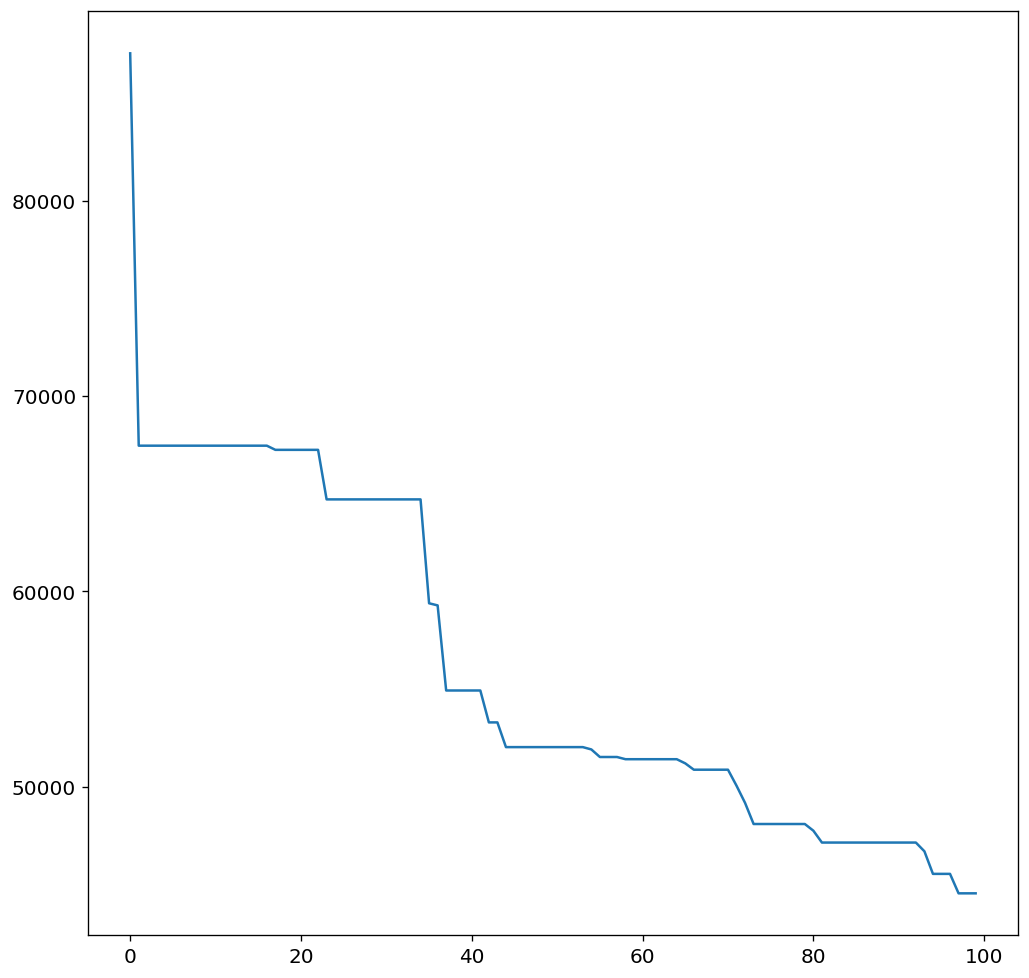

In [182]:
function = function_selector.get_function('f02')
fitness_function = function['func']
dimension = function['dimension']
lower_bound = function['domain'][0]
upper_bound = function['domain'][1]
global_min = function['global_min']
scale = False
apply_mutation = False
mutation_probability = 0.2
mix_rate = 1

env = OptimizationEnv(fitness_function, dimension=dimension, lower_bound=lower_bound, 
                      upper_bound=upper_bound, swarm_size=40, scale=scale, ep_length=100, 
                      neighborhood_size=10, mutation_probability=mutation_probability, 
                      log_scale=True, apply_mutation=apply_mutation, mix_rate=mix_rate)


obs = env.reset()
gbests = []
actions_min = []
actions_max = []
for step in range(env.ep_length):
    actions = get_action(env)
    actions_min.append(actions.min())
    actions_max.append(actions.max())
    #print(actions.min(), actions.max())
    obs, reward, done, info = env.step(actions)
    gbests.append(env.gbest_value)
    if step == env.ep_length - 1:
        print(f"Episode completed - Gbest value: {env.fitness_values.min()}")
        
plt.plot(gbests)
# print number of function evaluations
print(env.evaluation_counter)
    



In [187]:
import os
def train(env, agent_policy, config, title="experiment_1", **kwargs):
    neptune_logger = kwargs.get("neptune_logger", None)
        
    save_path = kwargs.get("save_path", "training_results/")
    save_path = os.path.join(save_path, title)
    # make directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    n_episodes = config["n_episodes"]
    average_returns = []  
    timestep = 0    
    for i in range(n_episodes):
        #print(f"Episode {i} started, timestep {timestep}")
        obs = env.reset()
        episode_return = np.zeros(env.swarm_size)
        for step in range(env.ep_length):
            #print(f"Episode {i}, step {step}, timestep {timestep}")
            actions = get_action(obs, agent_policy, env, obs_std=None)
            obs, reward, done, info = env.step(actions)
            for ag in range(env.swarm_size):
                agent_policy.buffer.rewards += [reward[ag]] * env.dimension
                agent_policy.buffer.is_terminals += [done] * env.dimension
            episode_return += reward
            timestep += 1
            if step == env.ep_length - 1:
                average_returns.append(np.mean(episode_return))
                if neptune_logger is not None:
                    neptune_logger["train/average_return"].log(average_returns[-1])
                running_average_rewards = np.mean(average_returns)

        if i % config["update_timestep"] == 0 and timestep > 0:
            #print(f"Updating policy at episode {i}")
            agent_policy.update()
        if i % config["log_interval"] == 0 and timestep > 0 :
            print(f"Episode {i} completed")
            print(f"Average return: {running_average_rewards}")
            if env.dimension == 2:
                env.renders(type="history", file_path=f"{save_path}/episode_{i}.gif")  
                if neptune_logger:
                    neptune_logger[f"train/gifs/{i}.gif"].upload(f"{save_path}/episode_{i}.gif")
        if i % config["decay_interval"] == 0 and timestep > 0:
            agent_policy.decay_action_std(config["decay_rate"], min_action_std=config["min_action_std"], debug=False)
        if i % config["save_interval"] == 0 and timestep > 0:
            if average_returns[-1] > running_average_rewards:
                print(f"Saving model at episode {i} with average return {average_returns[-1]} and running average {running_average_rewards}")
                agent_policy.save(save_path, episode=i)
        
    return agent_policy

from deephive.policies.mappo import MAPPO
def initialize(config, mode="train", **kwargs):
    # env = OptimizationEnv(config)
    agent_policy = MAPPO(config)
    if mode == "test" or mode == "benchmark":
        model_path = kwargs.get("model_path", None)
        if model_path is None:
            raise ValueError("Model path must be provided for testing")
        # check if model path is a list of paths
        if isinstance(model_path, list):
            agent_policies = []
            for path in model_path:
                agent_policy = MAPPO(config)
                agent_policy.load(path)
                agent_policies.append(agent_policy)
            return agent_policies
        else:
            agent_policy.load(model_path)
            return agent_policy
    else:
        return agent_policy
    
def get_action_p(observation, agent_policy, env, observation_std=None, **kwargs):
    # Ensure observation_info is a numpy array
    
    if not isinstance(observation, np.ndarray):
        observation = np.array(observation)
        assert observation.shape[0] == env.dimension, "Observation must have the same number of dimensions as the environment"
    # Initialize observation_std with zeros or use provided std, ensuring it matches the shape of observation
    if observation_std is None:
        observation_std = np.zeros_like(observation)
    else:
        observation_std = np.array(observation_std)

    # Flatten the observation and std arrays
    observation_flat = observation.reshape(env.dimension * env.swarm_size, -1)  # Flatten to 1D array
    observation_std_flat = observation_std.reshape(-1)  # Flatten to 1D array
    # Pass the entire flattened observation and std arrays to select_action
    action_flat = agent_policy.select_action(observation_flat, observation_std_flat)

    # Reshape the flattened action array back to the original (swarm_size, dimension) shape
    actions = action_flat.reshape(env.dimension, env.swarm_size).T  # Reshape to (n_agents, n_dim

    return actions  

In [188]:
from deephive.environment.utils import parse_config
mode = "train"
config_path = "../config/exp_config.json"
model_path = "../models/pbest_unfreeze.pth"
model_path_2 = "../models/gbest.pth"
config = parse_config(config_path)

config['use_gbest'] = False
config["use_optimal_value"] = True
config["log_scale"] = True
config["include_gbest"] = True
if config["include_gbest"]:
    config["obs_dim"] = 6
else:
    config["obs_dim"] = 4
config["ep_length"] = 25

config["min_action_std"] = 0.0001
config["action_std"] = 0.3
config["variable_std"]  = False
config["update_timestep"] = 2
config["decay_rate"] = 0.999
config["log_interval"] = 500
config["decay_interval"] = 5
config["save_interval"] = 200
mode = "train"
config["test_decay_rate"] = 0.9
config["test_decay_start"] = 0

config["reward_scheme"] = "FullRewardScheme2"
config["n_episodes"] = 5000
config["plot_gif"] = True
config["plot_gbest"] = True


config["n_agents"] = 10
config["n_dim"] = 2
config['objective_function'] = "SphereFunction" 
config["function_id"] = 6
agent_policy = initialize(config, mode=mode, model_path=[model_path, model_path_2])
if mode == "test":
    pbest_policy, gbest_policy = agent_policy[0], agent_policy[1]
else:
    agent_policy = agent_policy

In [189]:
function = function_selector.get_function('f01')
fitness_function = function['func']
dimension = 2#function['dimension']
lower_bound = function['domain'][0]
upper_bound = function['domain'][1]
global_min = function['global_min']
scale = False

env = OptimizationEnv(fitness_function, dimension=dimension, lower_bound=lower_bound, 
                      upper_bound=upper_bound, swarm_size=40, scale=scale, ep_length=config["ep_length"], 
                      neighborhood_size=2, mutation_probability=0, log_scale=True, apply_mutation=False)

In [ ]:
# neptune_logger = None #initialize_logger(api_token, "Deephive", config, mode=mode)
# agent_policy = train(env, agent_policy, config, title="experiment_13", neptune_logger=neptune_logger)

In [148]:
import torch
def get_direct_action(obs, obs_std, agent_policy):
    torch_obs = torch.FloatTensor(obs)
    torch_obs_std = torch.FloatTensor(obs_std)
    action = agent_policy.policy.act(torch_obs, torch_obs_std)
    return action


In [190]:
# obs = env.reset()
# obs_std = np.zeros_like(obs)
model_path = "training_results/experiment_11/policy-4200.pth"
agent_policy.load(model_path)

Loaded policy from:  training_results/experiment_11/policy-4200.pth


In [191]:
agent_policy.set_action_std(0.001)    

Updating gbest value to: 616.5254796728361 from 616.6574197473993
Updating gbest value to: [616.52547967]
Updating gbest value to: 616.4351963289743 from 616.5254796728361
Updating gbest value to: [616.43519633]
Updating gbest value to: 616.2351484513657 from 616.4351963289743
Updating gbest value to: [616.23514845]
Updating gbest value to: 616.1485171062886 from 616.2351484513657
Updating gbest value to: [616.14851711]
Updating gbest value to: 616.0783584507246 from 616.1485171062886
Updating gbest value to: [616.07835845]
Updating gbest value to: 615.9494116501613 from 616.0783584507246
Updating gbest value to: [615.94941165]
Updating gbest value to: 615.8596951435346 from 615.9494116501613
Updating gbest value to: [615.85969514]
Updating gbest value to: 615.7437886854057 from 615.8596951435346
Updating gbest value to: [615.74378869]
Updating gbest value to: 615.7023929505361 from 615.7437886854057
Updating gbest value to: [615.70239295]
Updating gbest value to: 615.5892217830567 fro

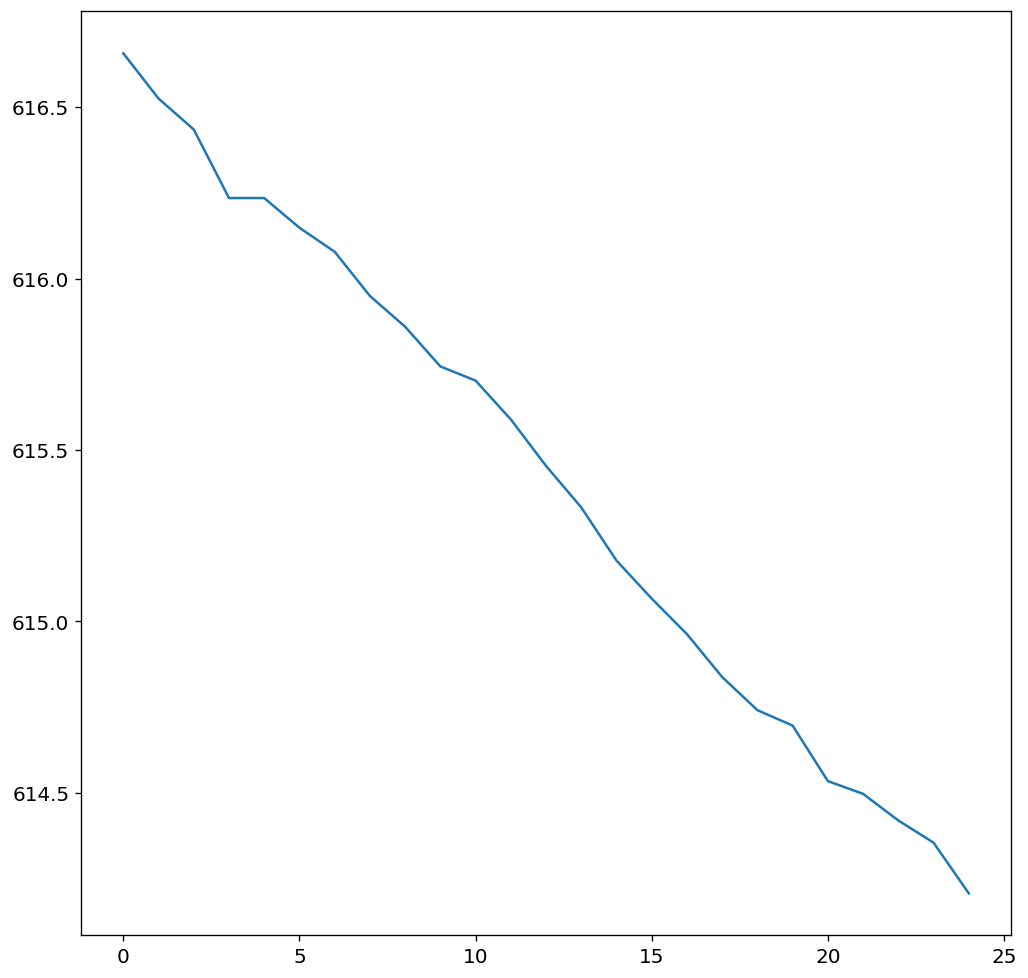

In [194]:

obs = env.reset()
episode_return = np.zeros(env.swarm_size)
gbests = []
for step in range(env.ep_length):
    #print(f"Episode {i}, step {step}, timestep {timestep}")
    actions = get_action_p(obs, agent_policy, env, obs_std=None)
    # print minimum action and maximum action
    #print(actions.min(), actions.max())
    obs, reward, done, info = env.step(actions)
    gbests.append(env.gbest_value)
    if step == env.ep_length - 1:
        print(f"Episode completed - Gbest value: {env.fitness_values.min()}")
        
plt.plot(gbests)
    


In [156]:
env.fitness_values.min()

5.270143904062552

In [ ]:
env.renders(type="history", file_path="test2.gif")

In [ ]:
agent_policy.set_action_std(0.01)

In [ ]:
obs_std = np.zeros_like(obs)
action, _ = get_direct_action(obs, obs_std, agent_policy)
print(action)

In [ ]:
import os
def test(env, agent_policy, n_episodes=1, title="experiment_1", **kwargs):
    neptune_logger = kwargs.get("neptune_logger", None)
        
    save_path = kwargs.get("save_path", "training_results/")
    save_path = os.path.join(save_path, title)
    # make directory if it does not exist
    for i in range(n_episodes):
        #print(f"Episode {i} started, timestep {timestep}")
        obs = env.reset()
        episode_return = np.zeros(env.swarm_size)
        for step in range(env.ep_length):
            #print(f"Episode {i}, step {step}, timestep {timestep}")
            actions = get_action(obs, agent_policy, env, obs_std=None)
            obs, reward, done, info = env.step(actions)
            if step == env.ep_length - 1:
                print(f"Episode {i} completed - Gbest value: {env.fit}")
        
    return agent_policy

    